# Naive Bayse

## 1.preprocess

In [621]:
import pickle
pkl_label = open('./Datasets/label.pkl', 'rb')
pkl_data = open('./Datasets/data.pkl', 'rb')
data = pickle.load(pkl_data)
label = pickle.load(pkl_label)

### 1
There is no one-size-fits-all answer to this question, as the optimal ratio may vary depending on the size of the dataset, the complexity of the problem, and the distribution of the data but usually we use somethis between 0.2 and 0.3.

In [622]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
label = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
# data[1].reshape()
data[1].reshape(420).shape

(420,)

### 2

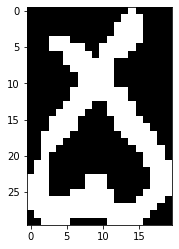

pixel values are between 0 and 255.


In [623]:
import matplotlib.pyplot as plt
import random

rnd_img = random.choice(X_train)
plt.imshow(rnd_img, cmap='gray')
plt.show()
print(f'pixel values are between {np.min(rnd_img)} and {np.max(rnd_img)}.')

### 3
It's better that all images have the same size because we want to calculate p(f|c) and we want all images to be in the same state. also reducing the size of images is computationally good.

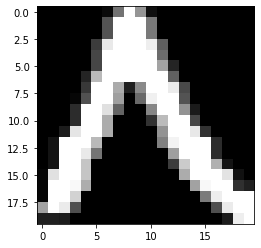

In [624]:
import cv2

reshape_list = lambda ls : [cv2.resize(li, (20, 20)) for li in ls]
X_train, X_test = reshape_list(X_train), reshape_list(X_test)
rnd_img = random.choice(X_train)
plt.imshow(rnd_img, cmap='gray')
plt.show()

### 4

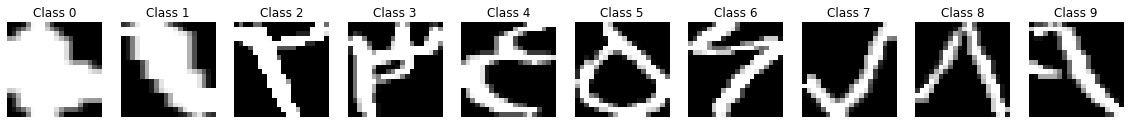

In [625]:
num_classes = 10
fig, axs = plt.subplots(1, num_classes, figsize=(20, 2))

for i in range(num_classes):
    class_indices = np.where(np.array(y_train) == i)[0]
    image_index = class_indices[0]
    image = X_train[image_index]

    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Class {i}')

### 5

(array([146., 164., 135., 145., 156., 134., 155., 157., 149., 159.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

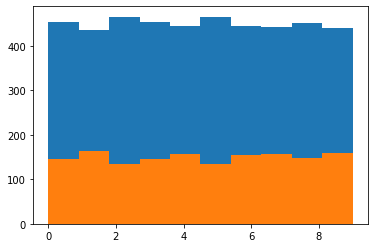

In [626]:
plt.hist(y_train, bins=10)
plt.hist(y_test, bins=10)


In [627]:
import pandas as pd
print('train: ')
pd.value_counts(y_train)

train: 


5    466
2    465
3    455
0    454
8    451
6    445
4    444
7    443
9    441
1    436
dtype: int64

In [628]:
print('test: ')
pd.value_counts(y_test)

test: 


1    164
9    159
7    157
4    156
6    155
8    149
0    146
3    145
2    135
5    134
dtype: int64

### 6
If we compare the pixel values of two images directly without scaling them, we may get inaccurate or misleading results. For example, an image with pixel values ranging from 0 to 255 may appear darker than an image with pixel values ranging from 0 to 1, even if the images have the same content. It could also results instability.

In [629]:
normalizer = lambda imgs : [img / img.max() for img in imgs]
X_train, X_test = normalizer(X_train), normalizer(X_test)

## 2.Problem Solving

### 7
* p(c) or class prior is our prior information on this problem. we could calculate it by the frequency of that  class in the dataset.
* likelihood is the probability of seeing this input if the class is c. we can consider different distributions for p(x|c).
* p(x) is the probability of seeing x but it's not important in classification because we want to compare. so it's constant for all c.
* posterior is our calculated probability after seeing data and we must compare these values together and choose the most one.

In [630]:
from abc import ABC, abstractmethod
class _IBaseNB(ABC):
    @abstractmethod
    def _joint_log_likelihood(self, X):
        pass
    def predict(self, X):
        # if is_fitted == False: 
        #     raise RuntimeError("you must fit first")
        jll = self._joint_log_likelihood(X)
        return self.classes[np.argmax(jll, axis=1)]
    
class IGaussianNB(_IBaseNB):
    def __init__(self, *, priors=None, var_smoothing=0):
        self.priors = priors
        self.var_smoothing = var_smoothing
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.means = np.zeros((self.n_classes, self.n_features))
        self.vars = np.zeros((self.n_classes, self.n_features))
        if self.priors == None:
            self.priors = np.ones(self.n_classes) / self.n_classes
        unique_y = np.unique(y)
        self.classes = unique_y
        for y_i in unique_y:
            X_i = X[y == y_i]
            self.means[y_i] = np.mean(X_i, axis=0) + self.var_smoothing
            self.vars[y_i] = np.var(X_i, axis=0) + self.var_smoothing
            self.priors[y_i] = (X_i.shape[0] + self.var_smoothing) / (X.shape[0] + self.var_smoothing * self.n_classes)
    def _joint_log_likelihood(self, X):
        joint_log_likelihood = []
        X = np.asarray(X)
        # print(X.shape)
        # print(self.vars[1].shape)
        for class_i in range(np.size(self.classes)):
            prior_logs = np.log(self.priors[class_i])
            liklihood_log = -0.5 * np.sum(np.log(2 * np.pi * (self.vars[class_i])))
            liklihood_log -= np.sum((X - self.means[class_i]) ** 2 / (2 * (self.vars[class_i])), axis=1)
            joint_log_likelihood.append(prior_logs + liklihood_log)
        joint_log_likelihood = np.array(joint_log_likelihood).T
        # print(joint_log_likelihood.shape)
        return joint_log_likelihood
class IBernoulliNB(_IBaseNB):
    def __init__(self, *, priors=None, alpha=0):
        self.priors = priors
        self.alpha = alpha
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.p_x = np.zeros((self.n_classes, self.n_features))
        if self.priors == None:
            self.priors = np.ones(self.n_classes) / self.n_classes
        unique_y = np.unique(y)
        self.classes = unique_y
        for y_i in unique_y:
            X_i = X[y == y_i]
            self.p_x[y_i] = (np.count_nonzero(X_i, axis=0) + self.alpha) / (X_i.shape[0] + self.alpha * self.n_classes)
            self.priors[y_i] = (X_i.shape[0] + self.alpha) / (X.shape[0] + self.alpha * self.n_classes)
    def _joint_log_likelihood(self, X):
        joint_log_likelihood = []
        X = np.asarray(X)
        # print(X.shape)
        # print(self.vars[1].shape)
        for class_i in range(np.size(self.classes)):
            prior_logs = np.log(self.priors[class_i])
            liklihood_log = np.sum(X * np.log(self.p_x[class_i]) + (1 - X) * np.log(1 - self.p_x[class_i]), axis=1)
            joint_log_likelihood.append(prior_logs + liklihood_log)
        joint_log_likelihood = np.array(joint_log_likelihood).T
        # print(joint_log_likelihood.shape)
        return joint_log_likelihood

### 8
Because we have the product of p(x|c_i) and when one of these terms is zero or inf all of the expression be zero or inf so we. Naive Bayes works with seeing data and updating its knowledge so when all of the train data says the same thing model behaves with that as an absolute fact.

### 9
For preventing a zero or inf in p(x|c) we add a small value to the variance in Gaussian Naive Bayes. for Berneuli Naive Base we consider an alpha and add it to the numerator of the fraction and number of classes multiplied by alpha to the denominator. so we won't have any inf or zero value.

## 3.Metric

### 10
Because they say different things. For example, if a binary classifier predicts 1 for all test data recall is 1 because all of class one predicted truly and if we apply so high threshold we get high precision but we can't say it's a good classifier.

### 11
f1 score is a type of harmonic mean. The harmonic mean is a type of average that is used to calculate the central tendency of a set of numbers and gives more weight to smaller values in the set than the arithmetic mean. f1 score balances precision and recall and if it's low, we can say the model works badly somewhere.

### 12
* Macro-averaging: In macro-averaging, the metrics are calculated independently for each class, and then the average is taken across all classes.
* Micro-averaging: In micro-averaging, the metrics such as precision, recall, and F1 score are calculated globally by counting the total number of true positives, false positives, and false negatives across all classes. when each datapoint assigned to one class it's equall to accuracy.
* Weighted-averaging: In weighted averaging, the metrics are calculated for each class independently, and then weighted by the number of instances in each class.

In [631]:
from sklearn import metrics
def precision_score(y_true, y_pred):
    classes = np.sort(np.unique(y_true))
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    precision_list = []
    for class_i in classes:
        class_mask = y_pred == class_i
        precision_mask = y_pred[class_mask] == y_true[class_mask]
        precision_list.append(np.round(np.mean(precision_mask), decimals=2))
    precision_list = np.asarray(precision_list)
    return precision_list

def recall_score(y_true, y_pred):
    classes = np.sort(np.unique(y_true))
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    recall_list = []
    for class_i in classes:
        class_mask = y_true == class_i
        recall_mask = y_pred[class_mask] == y_true[class_mask]
        recall_list.append(np.round(np.mean(recall_mask), decimals=2))
    recall_list = np.asarray(recall_list)
    return recall_list

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = np.round(2 * precision * recall / (precision + recall), decimals=2)
    return f1

def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred).round(3)

def macro_avg(y_true, y_pred):
    precision_macro = precision_score(y_true, y_pred).mean().round(2)
    recall_macro = recall_score(y_true, y_pred).mean().round(2)
    f1_macro = f1_score(y_true, y_pred).mean().round(2)
    return precision_macro, recall_macro, f1_macro

def calculate_class_weights(y_true):
    y_true = np.asarray(y_true)
    classes = np.sort(np.unique(y_true))
    class_weights = []
    for i in range(len(classes)):
        class_weights.append(np.sum(y_true == classes[i]) / len(y_true))
    return class_weights

def weighted_avg(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    class_weights = calculate_class_weights(y_true)
    precision_weighted = np.average(precision_score(y_true, y_pred), weights=class_weights).round(2)
    recall_weighted = np.average(recall_score(y_true, y_pred), weights=class_weights).round(2)
    f1_weighted = np.average(f1_score(y_true, y_pred), weights=class_weights).round(2)
    return precision_weighted, recall_weighted, f1_weighted


### 13

In [632]:
def report(y_test, y_pred):
    test_dict = {}
    print(f' accuracy of Gaussian smooth: {accuracy_score(y_test, y_pred)}.')
    print(f' macro_avg of Gaussian smooth: {macro_avg(y_test, y_pred)}.')
    print(f' weighted_avg of Gaussian smooth: {weighted_avg(y_test, y_pred)}.')
    test_dict['precision'] = precision_score(y_test, y_pred)
    test_dict['recall'] = recall_score(y_test, y_pred)
    test_dict['f1'] = f1_score(y_test, y_pred)
    test_df = pd.DataFrame(test_dict)
    return test_df

In [633]:
x, y = X_train[20].shape
flatter = lambda X : [img.reshape(x * y) for img in X]
X_train_flatted, X_test_flatted = flatter(X_train), flatter(X_test)

In [634]:

gnb_non_smooth = IGaussianNB(var_smoothing=0)
gnb_non_smooth.fit(X_train_flatted, y_train)
y_pred = gnb_non_smooth.predict(X_test_flatted)
test_df = report(y_test, y_pred)
test_df

 accuracy of Gaussian smooth: 0.09.
 macro_avg of Gaussian smooth: (nan, 0.1, nan).
 weighted_avg of Gaussian smooth: (nan, 0.09, nan).


/tmp/ipykernel_24080/4059364158.py:39: RuntimeWarning: divide by zero encountered in log
  liklihood_log = -0.5 * np.sum(np.log(2 * np.pi * (self.vars[class_i])))
/tmp/ipykernel_24080/4059364158.py:40: RuntimeWarning: divide by zero encountered in divide
  liklihood_log -= np.sum((X - self.means[class_i]) ** 2 / (2 * (self.vars[class_i])), axis=1)
/tmp/ipykernel_24080/4059364158.py:40: RuntimeWarning: invalid value encountered in divide
  liklihood_log -= np.sum((X - self.means[class_i]) ** 2 / (2 * (self.vars[class_i])), axis=1)
/tmp/ipykernel_24080/4059364158.py:40: RuntimeWarning: invalid value encountered in subtract
  liklihood_log -= np.sum((X - self.means[class_i]) ** 2 / (2 * (self.vars[class_i])), axis=1)
/home/aidin/code/queraDataScience/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aidin/code/queraDataScience/venv/lib/python3.10/site-packages/numpy/core/_methods.

,precision,recall,f1
0,NaN,0.0,NaN
1,NaN,0.0,NaN
2,0.09,1.0,0.17
3,NaN,0.0,NaN
4,NaN,0.0,NaN
5,NaN,0.0,NaN
6,NaN,0.0,NaN
7,NaN,0.0,NaN
8,NaN,0.0,NaN
9,NaN,0.0,NaN


In [635]:

gnb_smooth = IGaussianNB(var_smoothing=1e-4)
gnb_smooth.fit(X_train_flatted, y_train)
y_pred = gnb_smooth.predict(X_test_flatted)
test_df = report(y_test, y_pred)
test_df

# print(metrics.classification_report(y_test, y_pred))

 accuracy of Gaussian smooth: 0.886.
 macro_avg of Gaussian smooth: (0.89, 0.88, 0.88).
 weighted_avg of Gaussian smooth: (0.89, 0.89, 0.88).


,precision,recall,f1
0,0.93,0.98,0.95
1,0.94,0.85,0.89
2,0.77,0.68,0.72
3,0.73,0.90,0.81
4,0.94,0.77,0.85
5,0.94,0.97,0.95
6,0.92,0.77,0.84
7,0.93,0.97,0.95
8,0.99,0.97,0.98
9,0.80,0.99,0.88


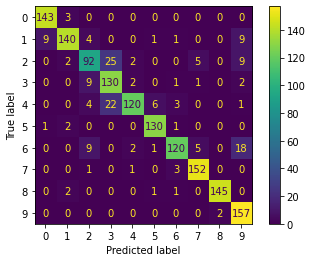

In [636]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [637]:
def bw(X, tresh=0.2):
    tresh_mask = X > tresh
    X[tresh_mask] = 1
    X[~tresh_mask] = 0
    return X
bw_X_train, bw_X_test = bw(np.asarray(X_train_flatted)), bw(np.asarray(X_test_flatted))


In [638]:

bnb_non_smooth = IBernoulliNB(alpha=0)
bnb_non_smooth.fit(bw_X_train, y_train)
y_pred = bnb_non_smooth.predict(bw_X_test)
test_df = report(y_test, y_pred)
test_df

 accuracy of Gaussian smooth: 0.091.
 macro_avg of Gaussian smooth: (nan, 0.1, nan).
 weighted_avg of Gaussian smooth: (nan, 0.09, nan).


/tmp/ipykernel_24080/4059364158.py:70: RuntimeWarning: divide by zero encountered in log
  liklihood_log = np.sum(X * np.log(self.p_x[class_i]) + (1 - X) * np.log(1 - self.p_x[class_i]), axis=1)
/tmp/ipykernel_24080/4059364158.py:70: RuntimeWarning: invalid value encountered in multiply
  liklihood_log = np.sum(X * np.log(self.p_x[class_i]) + (1 - X) * np.log(1 - self.p_x[class_i]), axis=1)
/home/aidin/code/queraDataScience/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aidin/code/queraDataScience/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_24080/2727836611.py:29: RuntimeWarning: invalid value encountered in divide
  f1 = np.round(2 * precision * recall / (precision + recall), decimals=2)


,precision,recall,f1
0,NaN,0.00,NaN
1,NaN,0.00,NaN
2,0.10,1.00,0.18
3,0.00,0.00,NaN
4,0.00,0.00,NaN
5,NaN,0.00,NaN
6,0.06,0.01,0.02
7,0.00,0.00,NaN
8,NaN,0.00,NaN
9,NaN,0.00,NaN


In [639]:
bnb_smooth = IBernoulliNB(alpha=0.1)
bnb_smooth.fit(bw_X_train, y_train)
y_pred = bnb_smooth.predict(bw_X_test)
test_df = report(y_test, y_pred)
test_df


 accuracy of Gaussian smooth: 0.9.
 macro_avg of Gaussian smooth: (0.9, 0.9, 0.9).
 weighted_avg of Gaussian smooth: (0.9, 0.9, 0.9).


,precision,recall,f1
0,0.87,0.99,0.93
1,0.92,0.84,0.88
2,0.77,0.77,0.77
3,0.85,0.85,0.85
4,0.95,0.87,0.91
5,0.93,0.99,0.96
6,0.96,0.77,0.85
7,0.95,0.99,0.97
8,1.00,0.98,0.99
9,0.82,0.97,0.89


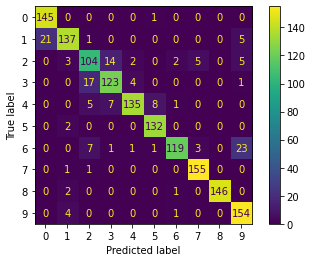

In [640]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()

### 14
Without additive smoothing everything is awful. Gaussian model predict everything to one class and we can say its not classifier! second one is a little better but it's awful yet. BernoulliNB is a little better than GaussainNB. Also we see that some classes are so accurate like 0, 8, 5 and 9 but some like 2 and 6 has more error. accuracy, precision and recall also macro_avg and weighted_avg are in same order so our classifier is balanced.

### 15

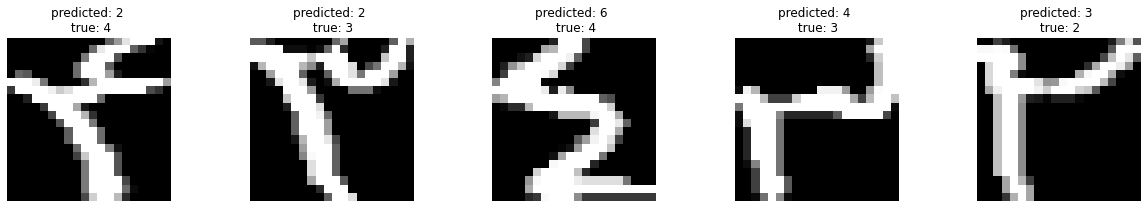

In [641]:
n_mistakes = 5
fig, axs = plt.subplots(1, n_mistakes, figsize=(21, 3))
mistake_mask = y_test != y_pred
class_indices = np.where(mistake_mask)[0]
for i in range(n_mistakes):
    image_index = class_indices[i]
    image = X_test[image_index]

    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'predicted: {y_pred[image_index]} \n true: {y_test[image_index]}')